# Import libraries

In [142]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm

# Initialize environment and parameters

In [150]:
env = gym.make("Roulette-v0").env

params = {
    "discount": 0.9,
    "alpha": 0.1,
    "eps": 0.01,
    "N": 10,
    "num_episodes": 100,
    "max_iters": 10000
}

# On Policy Monte Carlo method

In [151]:
class OnPolicyMCAgent():
    '''
    Models Monte Carlo RL agent which is trained using On Policy MC algorithm 
    '''
    def __init__(self, env, params):
        '''
        Method to initialize the On Policy MC agent model

        Input
        -----
        env     : Environment
        params  : Parameters for training and simulation
        '''
        self.env = env
        self.nS = env.observation_space.n
        self.nA = env.action_space.n
        self.params = params

        self.q_table = np.zeros((self.nS, self.nA))
        self.policy = np.random.randint(self.nA, size=self.nS)

    def get_action(self, state):
        '''
        Method to get action from input state using epsilon greedy policy on Q

        Input
        -----
        state  : Input state

        Output
        ------
        action : Output action based on epsilon greedy policy on Q
        '''
        if random.uniform(0, 1) < self.params["eps"]:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def get_action_policy(self, state, policy):
        '''
        Method to get action from input state using epsilon greedy policy on input policy

        Input
        -----
        state  : Input state
        policy : Input policy

        Output
        ------
        action : Output action based on epsilon greedy policy on Q
        '''
        if random.uniform(0, 1) < self.params["eps"]:
            return self.env.action_space.sample()
        else:
            return policy[state]

    def train_agent(self):
        '''
        Method to train agent using On Policy MC method
        '''
        self.q_table = np.random.rand(self.nS, self.nA)
        self.policy = np.random.randint(self.nA, size=self.nS)
        returns_table = {}
        for state in range(self.nS):
            for action in range(self.nA):
                returns_table[(state, action)] = []
        
        sum_rewards_N = []
        for i in tqdm(range(self.params["N"])):
            sum_rewards = []
            for ep in range(self.params["num_episodes"]):
                state = self.env.reset()
                done = False
                episode = []
                sum_R = 0
                iter = 0

                # Generate episode
                while not done and iter < self.params["max_iters"]:
                    action = self.get_action_policy(state, self.policy)

                    obs, reward, done, info = self.env.step(action)
                    sum_R += reward

                    episode.append((state, action, reward))
                    state = obs
                
                sum_rewards.append(sum_R)

                # Update returns and state-action values
                G = {}
                for (S, A, R) in episode:
                    if (S, A) not in G:
                        G[(S, A)] = 0
                    for tmp in G:
                        G[tmp] = self.params["discount"] * G[tmp] + R

                for tmp in G:
                    returns_table[tmp].append(G[tmp])

                for (S, A) in G:
                    self.q_table[S, A] = np.mean(returns_table[S, A])

                # Update policy
                for (S, A) in G:
                    self.policy[S] = np.argmax(self.q_table[S])

            sum_rewards_N.append(sum_rewards)

        self.policy = self.get_policy()
        return sum_rewards_N

    def get_policy(self):
        '''
        Getter method for policy using state-action values
        '''
        return np.argmax(self.q_table, axis=1)

    def get_policy_state(self, state):
        '''
        Getter method for policy of input state
        '''
        return self.policy[state]

    def get_nS(self):
        '''
        Getter method for number of states
        '''
        return self.nS

    def get_nA(self):
        '''
        Getter method for number of actions
        '''
        return self.nA

    def get_Q_sa_value(self, state, action):
        '''
        Getter method for state-action value
        '''
        return self.q_table[state, action]

  0%|          | 0/10 [00:00<?, ?it/s]

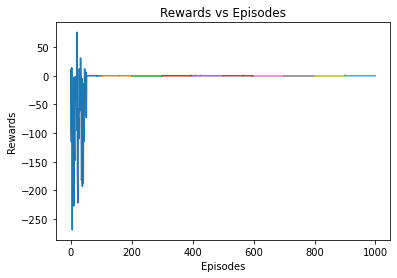

In [166]:
params = {
    "discount": 0.9,
    "alpha": 0.1,
    "eps": 0.01,
    "N": 10,
    "num_episodes": 100,
    "max_iters": 10000
}

on_policy_mc_agent = OnPolicyMCAgent(env, params)
sum_rewards = on_policy_mc_agent.train_agent()

len1 = len(sum_rewards[0])
x = np.arange(len1)
for sum_rew in sum_rewards:
    plt.plot(x, sum_rew)
    x += len1

plt.title("Rewards vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

The above plot is **sum of rewards vs episodes** graph over N runs. N was chosen to be 10. Hence, we trained agents using On Policy Monte Carlo method in 10 runs subsequently. As the agent is trained subsequently, the plot is created by appending the plots of subsequent run to the right. In each run, we trained the agent for 100 episodes.

From the above plot, we can observe that until around 80 episodes, the variance of sum of rewards is high, i.e., the state-action values learnt are not yet optimal or good until 80 episodes. Even though we used reasonably small epsilon value (0.01) for encouraging exploration, the agent seems to learn near optimal state-action values at around 80 episodes. After 80 episodes, we can see that for all subsequent runs, the sum of rewards is almost 0 with some very small variance. Hence, we can say that it takes around 80 episodes to learn good state-action values for this environment using On Policy Monte Carlo method.

In [167]:
on_policy_mc_agent.policy

array([37])

In the above cell, the optimal policy obtained after N runs is printed. We can see that the optimal action according to the policy learnt is action 37, which is to leave the game. This is evident that the rewards in the game Roulette is maximized only when we leave the game, because longer we stay in the game, more the losses we incur.

# Off Policy Monte Carlo method

In [204]:
class OffPolicyMCAgent():
    '''
    Models Monte Carlo RL agent which is trained using Off Policy MC method
    '''
    def __init__(self, env, params):
        '''
        Method to initialize the Off Policy MC agent model

        Input
        -----
        env     : Environment
        params  : Parameters for training and simulation
        '''
        self.env = env
        self.nS = env.observation_space.n
        self.nA = env.action_space.n
        self.params = params

        self.q_table = np.random.rand(self.nS, self.nA)
        self.policy = np.argmax(self.q_table, axis=1)

    def get_action_policy(self, state, policy):
        '''
        Method to get action from input state using epsilon greedy policy on input policy

        Input
        -----
        state  : Input state
        policy : Input policy

        Output
        ------
        action : Output action based on epsilon greedy policy on Q
        '''
        if random.uniform(0, 1) < self.params["eps"]:
            return self.env.action_space.sample()
        else:
            return policy[state]

    def train_agent(self):
        '''
        Method to train agent using Off Policy MC method
        '''
        self.q_table = np.random.rand(self.nS, self.nA)
        c_table = np.zeros((self.nS, self.nA))
        self.policy = np.argmax(self.q_table, axis=1)
        
        sum_rewards_N = []
        for i in tqdm(range(self.params["N"])):
            sum_rewards = []
            for ep in range(self.params["num_episodes"]):
                b = np.random.randint(self.nA, size=self.nS)

                state = self.env.reset()
                done = False
                episode = []
                sum_R = 0

                while not done:
                    action = self.get_action_policy(state, b)

                    obs, reward, done, info = self.env.step(action)
                    sum_R += reward

                    episode.append((state, action, reward))
                    state = obs

                sum_rewards.append(sum_R)

                G, W = 0, 1
                for (S, A, R) in list(reversed(episode)):
                    G = self.params["discount"] * G + R
                    c_table[S, A] += W
                    self.q_table[S, A] += W * (G - self.q_table[S, A]) / c_table[S, A]
                    self.policy[S] = np.argmax(self.q_table[S])

                    if A != self.policy[S]:
                        break

                    if b[S] == A:
                        W = W / (1 - self.params["eps"] + self.params["eps"] / self.nA)
                    else:
                        W = W / (self.params["eps"] / self.nA)
            
            sum_rewards_N.append(sum_rewards)
        
        self.policy = self.get_policy()
        return sum_rewards_N

    def get_policy(self):
        '''
        Getter method for policy using state-action values
        '''
        return np.argmax(self.q_table, axis=1)

    def get_policy_state(self, state):
        '''
        Getter method for policy of input state
        '''
        return self.policy[state]

    def get_nS(self):
        '''
        Getter method for number of states
        '''
        return self.nS

    def get_nA(self):
        '''
        Getter method for number of actions
        '''
        return self.nA

    def get_Q_sa_value(self, state, action):
        '''
        Getter method for state-action value
        '''
        return self.q_table[state, action]

  0%|          | 0/15 [00:00<?, ?it/s]

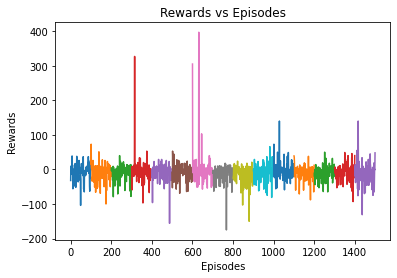

In [230]:
params = {
    "discount": 0.9,
    "alpha": 0.1,
    "eps": 0.1,
    "N": 15,
    "num_episodes": 100,
    "max_iters": 10000
}

off_policy_mc_agent = OffPolicyMCAgent(env, params)
sum_rewards = off_policy_mc_agent.train_agent()

len1 = len(sum_rewards[0])
x = np.arange(len1)
for sum_rew in sum_rewards:
    plt.plot(x, sum_rew)
    x += len1

plt.title("Rewards vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

The above plot is **sum of rewards vs episodes** graph over N runs. N was chosen to be 10. Hence, we trained agents using On Policy Monte Carlo method in 10 runs subsequently. As the agent is trained subsequently, the plot is created by appending the plots of subsequent run to the right. In each run, we trained the agent for 100 episodes.

We see that there is lot of variance in the plot. This is because in Off Policy MC method, we use different policies for generation episodes and learning. Due to which the learnt policy might not always to optimal. Infact we use different epsilon greedy policy in each episode, hence, the variance is high.

In [231]:
off_policy_mc_agent.policy

array([26])

In the above cell, the optimal policy obtained after N runs is printed. We can see that the optimal action according to the policy learnt is action 26, which is not the action to leave the game. This could be because of the nature of Off Policy MC method. As we are using episodes generated by some other epsilon soft policy to learn optimal policy, it could have learnt this action.

# Q Learning (Temporal Difference) method

In [173]:
class QLearningTDAgent():
    '''
    Models Temporal Difference RL agent which is trained using Q Learning method
    '''
    def __init__(self, env, params):
        '''
        Method to initialize the Q Learning agent model

        Input
        -----
        env     : Environment
        params  : Parameters for training and simulation
        '''
        self.env = env
        self.nS = env.observation_space.n
        self.nA = env.action_space.n
        self.params = params

        self.q_table = np.zeros((self.nS, self.nA))
        self.policy = np.random.randint(self.nA, size=self.nS)

    def get_action(self, state):
        '''
        Method to get action from input state using epsilon greedy policy on Q

        Input
        -----
        state  : Input state

        Output
        ------
        action : Output action based on epsilon greedy policy on Q
        '''
        if random.uniform(0, 1) < self.params["eps"]:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def train_agent(self):
        '''
        Method to train agent using Q Learning method
        '''
        self.q_table = np.zeros((self.nS, self.nA))
        
        sum_rewards_N = []
        for i in tqdm(range(self.params["N"])):
            sum_rewards = []
            for ep in range(self.params["num_episodes"]):
                sum_R = 0
                state = self.env.reset()
                done = False
                iter = 0

                while not done and iter < self.params["max_iters"]:
                    action = self.get_action(state)

                    obs, reward, done, info = self.env.step(action)
                    sum_R += reward

                    self.q_table[state, action] += self.params["alpha"] * (reward + self.params["discount"] * np.max(self.q_table[obs]) - self.q_table[state, action])

                    state = obs
                    iter += 1

                sum_rewards.append(sum_R)

            sum_rewards_N.append(sum_rewards)

        self.policy = self.get_policy()

        return sum_rewards_N

    def get_policy(self):
        '''
        Getter method for policy using state-action values
        '''
        return np.argmax(self.q_table, axis=1)

    def get_policy_state(self, state):
        '''
        Getter method for policy of input state
        '''
        return self.policy[state]

    def get_nS(self):
        '''
        Getter method for number of states
        '''
        return self.nS

    def get_nA(self):
        '''
        Getter method for number of actions
        '''
        return self.nA

    def get_Q_sa_value(self, state, action):
        '''
        Getter method for state-action value
        '''
        return self.q_table[state, action]

  0%|          | 0/10 [00:00<?, ?it/s]

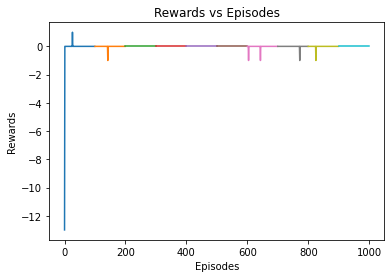

In [177]:
params = {
    "discount": 0.9,
    "alpha": 0.1,
    "eps": 0.01,
    "N": 10,
    "num_episodes": 100,
    "max_iters": 10000
}

q_learning_agent = QLearningTDAgent(env, params)
sum_rewards = q_learning_agent.train_agent()

len1 = len(sum_rewards[0])
x = np.arange(len1)
for sum_rew in sum_rewards:
    plt.plot(x, sum_rew)
    x += len1

plt.title("Rewards vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

The above plot is **sum of rewards vs episodes** graph over N runs. N was chosen to be 10. Hence, we trained agents using On Policy Monte Carlo method in 10 runs subsequently. As the agent is trained subsequently, the plot is created by appending the plots of subsequent run to the right. In each run, we trained the agent for 100 episodes.

From the above plot, we can observe that the policies attain near optimal values around 10-15 episodes itself, because we can see that until then the sum of rewards are highly varying (high variance), but after that the sum of rewards of almost 0. Even though we used reasonably small epsilon value (0.01) for encouraging exploration, the agent seems to learn near optimal state-action values very quick. As we can see that the sum of rewards are near 0 after 10-15 episodes, we can say that it takes around 10 episodes to learn good state-action values for this environment using Q Learning (TD) method. Even though sometimes in between, we can see spikes in rewards, its due to exploration happening during that time (some randomness introduced)

In [178]:
q_learning_agent.policy

array([37])

In the above cell, the optimal policy obtained after N runs is printed. We can see that the optimal action according to the policy learnt is action 37, which is to leave the game. This is evident that the rewards in the game Roulette is maximized only when we leave the game, because longer we stay in the game, more the losses we incur.

# Sarsa (Temporal Difference) method

In [185]:
class SarsaTDAgent():
    '''
    Models Temporal Difference RL agent which is trained using SARSA method
    '''
    def __init__(self, env, params):
        '''
        Method to initialize the SARSA agent model

        Input
        -----
        env     : Environment
        params  : Parameters for training and simulation
        '''
        self.env = env
        self.nS = env.observation_space.n
        self.nA = env.action_space.n
        self.params = params

        self.q_table = np.zeros((self.nS, self.nA))
        self.policy = np.random.randint(self.nA, size=self.nS)

    def get_action(self, state):
        '''
        Method to get action from input state using epsilon greedy policy on Q

        Input
        -----
        state  : Input state

        Output
        ------
        action : Output action based on epsilon greedy policy on Q
        '''
        if random.uniform(0, 1) < self.params["eps"]:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def train_agent(self):
        '''
        Method to train agent using SARSA method
        '''
        self.q_table = np.zeros((self.nS, self.nA))
        
        sum_rewards_N = []
        for i in tqdm(range(self.params["N"])):
            sum_rewards = []
            for ep in range(self.params["num_episodes"]):
                sum_R = 0
                state = env.reset()
                done = False
                iter = 0

                action = self.get_action(state)

                while not done and iter < self.params["max_iters"]:
                    obs, reward, done, info = self.env.step(action)
                    sum_R += reward

                    next_action = self.get_action(obs)

                    self.q_table[state, action] += self.params["alpha"] * (reward + self.params["discount"] * self.q_table[obs, next_action] - self.q_table[state, action])

                    state = obs
                    action = next_action
                    iter += 1

                sum_rewards.append(sum_R)

            sum_rewards_N.append(sum_rewards)

        self.policy = self.get_policy()
        
        return sum_rewards_N

    def get_policy(self):
        '''
        Getter method for policy using state-action values
        '''
        return np.argmax(self.q_table, axis=1)

    def get_policy_state(self, state):
        '''
        Getter method for policy of input state
        '''
        return self.policy[state]

    def get_nS(self):
        '''
        Getter method for number of states
        '''
        return self.nS

    def get_nA(self):
        '''
        Getter method for number of actions
        '''
        return self.nA

    def get_Q_sa_value(self, state, action):
        '''
        Getter method for state-action value
        '''
        return self.q_table[state, action]

  0%|          | 0/10 [00:00<?, ?it/s]

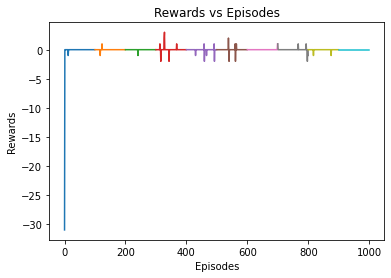

In [187]:
params = {
    "discount": 0.9,
    "alpha": 0.1,
    "eps": 0.01,
    "N": 10,
    "num_episodes": 100,
    "max_iters": 10000
}

sarsa_agent = SarsaTDAgent(env, params)
sum_rewards = sarsa_agent.train_agent()

len1 = len(sum_rewards[0])
x = np.arange(len1)
for sum_rew in sum_rewards:
    plt.plot(x, sum_rew)
    x += len1

plt.title("Rewards vs Episodes")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

The above plot is **sum of rewards vs episodes** graph over N runs. N was chosen to be 10. Hence, we trained agents using On Policy Monte Carlo method in 10 runs subsequently. As the agent is trained subsequently, the plot is created by appending the plots of subsequent run to the right. In each run, we trained the agent for 100 episodes.

From the above plot, we can observe that the policies attain near optimal values around 10-15 episodes itself, because we can see that until then the sum of rewards are highly varying (high variance), but after that the sum of rewards of almost 0. Even though we used reasonably small epsilon value (0.01) for encouraging exploration, the agent seems to learn near optimal state-action values very quick. As we can see that the sum of rewards are near 0 after 10-15 episodes, we can say that it takes around 10 episodes to learn good state-action values for this environment using Sarsa (TD) method.

In [188]:
sarsa_agent.policy

array([37])

In the above cell, the optimal policy obtained after N runs is printed. We can see that the optimal action according to the policy learnt is action 37, which is to leave the game. This is evident that the rewards in the game Roulette is maximized only when we leave the game, because longer we stay in the game, more the losses we incur.

# Comparison between four methods

Comparing all 4 methods, we see that Temporal Difference methods do better than Monte Carlo methods. This could be because of usage of state-action values in TD methods as opposed to that in MC methods. In MC methods, we solely depend of simulations to update the state action values, i.e., we do not bootstrap in MC methods. But on the contrary in TD methods, we use state-action values for the update, i.e., we do bootstrap in TD methods. Hence, this could be the reason for better performance of TD methods over MC methods.

In MC methods, we can see that On Policy MC method performs better than Off Policy MC method. This is because in On Policy MC method, we use the same policy to simulate and update the policy, whereas in Off Policy MC method, we use a separate epsilon soft policy to simulate and use another policy for learning. Even though we use Importance Sampling, the variance cannot be reduced to zero in Off Policy MC method, because of usage of different policies. However, it learns reasonably good policy as we can see that it very converges towards 0 (even though not completely).

In TD methods, we can see from the plot that both methods (Sarsa and Q Learning) are having almost same performance. But however, we see that in Sarsa the variance around 0 is lesser when compared to Q Learning method. Hence, in the above run training and simulations, Sarsa seems to exceed in performance than Q learning

We can estimate the number of episodes taken to learn the near optimal policy using the plots given above (sum of rewards vs episodes) by looking at when it converges (low variance along y axis).

We can see that On Policy MC method takes around 80 episodes to converge to an near optimal policy, whereas Off POlicy MC method have lot of variance even after 2000 episodes. Q Learning and Sarsa TD methods take only around 10-15 episodes to learn the near optimal policy.